## Thermal Conductivity Fit Analysis
### Developed by Henry Nachman
#### Last Edited: 21 January 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import h5py
import sys

from utility_functions import *

First, we need to find where all our RAW data is

In [2]:
os.chdir(f"{sys.path[0]}\\FITS")
mat_directories = [x[0] for x in os.walk(os.getcwd())]
mat_directories = [os.path.split(path)[-1] for path in mat_directories]
mat_directories = mat_directories[1:]
print(f"Found {len(mat_directories)} material directories: {mat_directories}")

Found 2 material directories: ['SS304', 'SS305']


Next, we need to extract each file.

In [3]:
def get_datafiles(material_name):
    all_files = os.listdir(material_name)
    extension = ".csv"
    raw_files = [file for file in all_files if file.endswith(extension)]
    print(f"For material {material_name}, found {len(raw_files)} measurements.")
    return raw_files

Now, we need to extract that data and store it in one central file.

In [4]:
def extract_RAW(material_name, raw_files):
    file_name = f"{material_name}.lh5"
    with h5py.File(file_name, "w") as material_file:
            counter = 0
            for raw_file in raw_files:
                # print(raw_file)
                file1 = np.loadtxt(f"{material_name}/{raw_file}", dtype=str, delimiter=',')
                ref = file1[0,:]
                ref_encode = [s.encode('utf-8') for s in ref]
                headers = file1[1,:]
                data_RAW = np.asarray(file1[2:,:], dtype=float)
                group = material_file.create_group(f"ref{counter}")
                ref_set = material_file[f"ref{counter}"].create_dataset("ref_info", (3,), data=ref_encode)
                raw_set = material_file[f"ref{counter}"].create_dataset("raw_data", data=data_RAW)
                counter += 1
            print(f"Material lh5 file has been saved with filename {file_name}")

For every one of the materials found above, we will make use of the above defined functions to create one compiled data file for each material.

In [5]:
for mat in mat_directories:
    files_list = get_datafiles(mat)
    extract_RAW(mat, files_list)

For material SS304, found 8 measurements.
Material lh5 file has been saved with filename SS304.lh5
For material SS305, found 2 measurements.
Material lh5 file has been saved with filename SS305.lh5


Now that we have compiled data files, lets do something with that data.

First, we need to find those files we just created.

In [6]:
all_files = os.listdir(f"{os.getcwd()}")
print(all_files)
extension = ".lh5"
raw_files = [file for file in all_files if file.endswith(extension)]
raw_names = [os.path.splitext(name)[0] for name in raw_files]
print(f"Found {len(raw_names)}, lh5 material files: {raw_names}")

['SS304', 'SS304.lh5', 'SS305', 'SS305.lh5']
Found 2, lh5 material files: ['SS304', 'SS305']


Let's grab all the data from each individual measurement, and group it all together.

In [7]:
def compile_measurements(material_name, plots=False):
    with h5py.File(f"{material_name}.lh5", "r") as f:
            if plots:
                 fig, axs = plt.subplots(2, 2, figsize=(8, 6))
            big_data = np.empty((3,))
            for key in f.keys():
                big_data = np.vstack((big_data, np.array(f[f"{key}/raw_data"])))
                T   = np.array(f[f"{key}/raw_data"])[:,0]
                k   = np.array(f[f"{key}/raw_data"])[:,1]
                koT = np.array(f[f"{key}/raw_data"])[:,2]
                if plots:
                    axs[0, 0].plot(T, k, '.', label=key)
                    axs[0, 1].plot(T, koT, '.', label=key)
                    axs[1, 0].plot(np.log10(T), np.log10(k),'.')
                    axs[1, 1].plot(np.log10(T), np.log10(koT),'.')
            
            if plots:
                axs[0,0].set_xlabel("T")
                axs[0,0].set_ylabel("k")
                axs[0,1].set_xlabel("T")
                axs[0,1].set_ylabel("k/T")
                axs[1,0].set_xlabel("log10(T)")
                axs[1,0].set_ylabel("log10(k)")
                axs[1,1].set_xlabel("log10(T)")
                axs[1,1].set_ylabel("log10(k/T)")

                plt.subplots_adjust(wspace=0.4, hspace=0.4)
                axs[0,1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
                plt.show()
            big_data = big_data[2:,:]
    return big_data

Now, for each material, we will fit the data. 
The fitting works by first splitting the data at a specified temperature value (thresh),

For low T the fit is between: T vs k/T

for high T the fit is between: log10(T) vs log10(k)

In [8]:
def fit_thermal_conductivity(big_data, thresh = 20, fit_orders = (2,3), fit_types=("k/T", "loglog"), plots=False):
    # thresh     : 20    : The temperature threshold to split low and high data   
    # fit_orders : (2,3) : The polynomial order for the low and high fits respectively

    # divide the data array into three columns
    T = big_data[:,0]
    k = big_data[:,1]
    koT = big_data[:,2]

    # Set a temperature threshold for split between hi and low fits
    thresh = 20 # in K

    # Find the low range
    lowT = T[T<thresh]
    lowT_k = k[T<thresh]
    lowT_koT = koT[T<thresh]

    # Find the high range
    hiT = T[T>thresh]
    hiT_k = k[T>thresh]
    # Take a log10 of the high range
    log_hi_T = np.log10(hiT)
    log_hi_k = np.log10(hiT_k)

    # Fit the low data
    if fit_types[0] == "k/T":
        low_fit = np.polyfit(lowT, lowT_koT, fit_orders[0])
        low_fit_xs = np.linspace(np.min(lowT), np.max(lowT), 100)
        low_poly1d = np.poly1d(low_fit)


    # Fit the high data
    if fit_types[1] == "loglog":
        hi_fit = np.polyfit(log_hi_T, log_hi_k, fit_orders[1])
        hi_fit_xs = np.linspace(np.min(log_hi_T), np.max(log_hi_T), 100)
        hi_poly1d = np.poly1d(hi_fit)


    if plots:
        fig, axs = plt.subplots(2, figsize=(8, 6))
        axs[0].plot(lowT, lowT_koT,'.')
        axs[0].plot(low_fit_xs, np.polyval(low_fit, low_fit_xs))
        axs[0].set_xlabel("T")
        axs[0].set_ylabel("k/T")
        axs[0].title.set_text("Low Temperature Fit")
        # axs[1].plot(hi_fit_xs, np.polyval(hi_fit, hi_fit_xs))
        # axs[1].plot(log_hi_T, log_hi_k, '.')
        axs[1].loglog(10**hi_fit_xs, 10**np.polyval(hi_fit, hi_fit_xs))
        axs[1].loglog(hiT, hiT_k, '.')
        axs[1].grid(True, which="both", ls="-", color='0.65')
        axs[1].set_ylabel("k")
        axs[1].set_xlabel("T")
        axs[1].title.set_text("High Temperature Fit")
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.show()
        
    low_func = f"{fit_orders[0]} order {fit_types[0]}"
    hi_func = f"{fit_orders[1]} order {fit_types[1]}"
    return [low_func, low_fit, hi_func, hi_fit, thresh, max(hiT)]


While we are at it, we want a way to be able to save all the new fits into one nice file we can reference later. Note, this function references functions defined in the utility file.

In [9]:
def save_tc_lh5file(material_args):
    os.chdir(os.path.split(os.getcwd())[0])
    comp_file = "ThermalConductivityFits.lh5"
    with h5py.File(comp_file, "w") as f:
        for i in range(len(material_args)):
            [low_fits, low_params, hi_fits, hi_params, thresholds, hiTs, material_names] = material_args[i]
            f.create_group(f"{material_names}")
            f[f"{material_names}"].create_group("low_fit")
            f[f"{material_names}"].create_group("hi_fit")
            # low_fit_print = f"\n%s" %low_fits
            # hi_fit_print = f"\n%s" %hi_fits
            f[f"{material_names}/low_fit"].create_dataset("fit_function", data=low_fits)
            f[f"{material_names}/low_fit"].create_dataset("fit_params", data=low_params)
            f[f"{material_names}/low_fit"].create_dataset("fit_range", data=[0,thresholds])
            f[f"{material_names}/hi_fit"].create_dataset("fit_function", data=hi_fits)
            f[f"{material_names}/hi_fit"].create_dataset("fit_params", data=hi_params)
            f[f"{material_names}/hi_fit"].create_dataset("fit_range", data=[thresholds, hiTs])
    os.chdir(f"{os.getcwd()}\\FITS")

def lh5_to_txt(lh5_file):
    os.chdir(os.path.split(os.getcwd())[0])
    comp_file = "ThermalConductivityFits.txt"
    f = open(comp_file, "w")

def save_tc_txtfile(material_args):
    os.chdir(os.path.split(os.getcwd())[0])
    comp_file = "ThermalConductivityFits.txt"
    f = open(comp_file, "w")
    for i in range(len(material_args)):
        [low_fits, hi_fits, thresholds, hiTs, material_names] = material_args[i]
        f.write(f"{material_names}\n")
        f.write("low_fit\n")
        f.write(f"fit_param {low_fits}\n")
        f.write(f"fit_range: {[0,thresholds]}\n")
        f.write("hi_fit\n")
        f.write(f"fit_function {hi_fits}\n")
        f.write(f"fit_range: {[thresholds, hiTs]}\n")
        f.write("\n")
    os.chdir(f"{os.getcwd()}\\FITS")

Let's run those functions

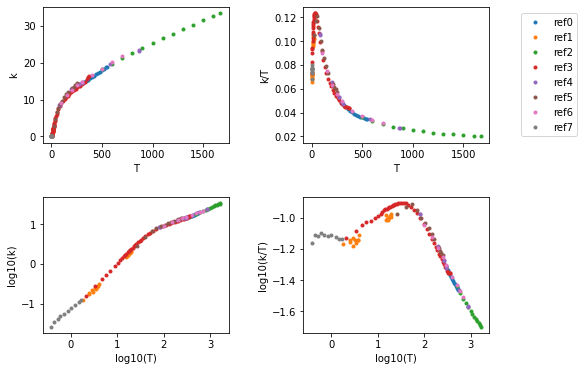

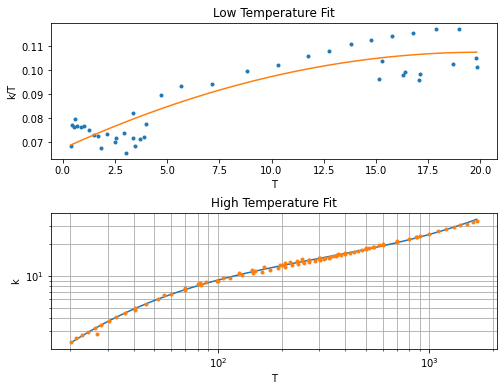

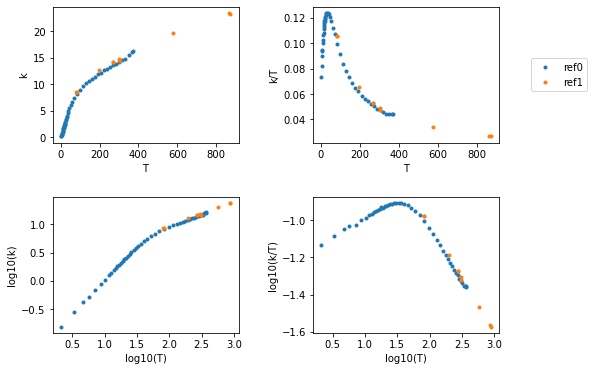

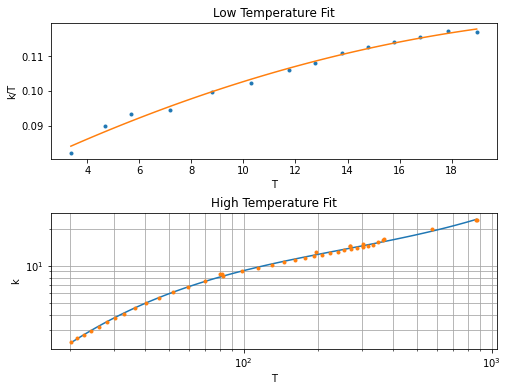

In [10]:
material_arguments = np.empty((len(raw_names),), dtype=object) #np.empty((5,), dtype=object)
for i in range(len(raw_names)):
    mat = raw_names[i]
    big_data = compile_measurements(mat, plots=True)
    ref_vals = fit_thermal_conductivity(big_data, thresh = 20, fit_orders = (2,3), plots=True)
    ref_vals = np.array(ref_vals, dtype=object)
    ref_vals = np.append(ref_vals, mat)
    material_arguments[i] = ref_vals

save_tc_lh5file(material_arguments)
# save_tc_txtfile(material_arguments)

In [14]:
open_file = "ThermalConductivityFits.lh5"

with h5py.File(open_file, 'r') as f:
    keys = openGroup(f, [])
    comp_file = "ThermalConductivityFits.txt"
    sf = open(comp_file, "w")
    for key in keys:
        # print(key)
        arr = np.array(f[f"{key}"])
        sf.write(key)
        sf.write("\n    ")
        sf.write(str(arr))
        sf.write("\n        ")
        sf.write("\n")
        
print(keys)
os.chdir(f"{os.getcwd()}\\FITS")

c:\Users\henac\OneDrive - The University of Texas at Austin\01_RESEARCH\05_CMBS4\Cryogenic_material_Properties\dev
['//SS304', '/SS304/hi_fit', '/SS304/hi_fit/fit_function', '/SS304/hi_fit/fit_params', '/SS304/hi_fit/fit_range', '/SS304/low_fit', '/SS304/low_fit/fit_function', '/SS304/low_fit/fit_params', '/SS304/low_fit/fit_range', '//SS305', '/SS305/hi_fit', '/SS305/hi_fit/fit_function', '/SS305/hi_fit/fit_params', '/SS305/hi_fit/fit_range', '/SS305/low_fit', '/SS305/low_fit/fit_function', '/SS305/low_fit/fit_params', '/SS305/low_fit/fit_range']


In [12]:
def printname(name):
    print(name)

open_file = "SS304.lh5"
print(os.getcwd())
with h5py.File(open_file, "r") as f:
    # print(f.visit(printname))
    for ref in f.keys():
        print(ref)
        refinfo = np.array(f[f"{ref}/ref_info"], dtype=str)
        data = np.array(f[f"{ref}/raw_data"])
        print(refinfo)
        print(data)
        print("\n")
        print("---")
        print("\n")

c:\Users\henac\OneDrive - The University of Texas at Austin\01_RESEARCH\05_CMBS4\Cryogenic_material_Properties\dev\FITS
ref0
['Reference correlations for the thermal conductivity of solid BK7 - PMMA - Pyrex 7740 - Pyroceram 9606 and SS304'
 'K.D. Antoniadis - A. Tyrou - M.J. Assael - X. Li - J. Wu - and H.P. Ebert'
 'International Journal of Thermophysics 41:98 (2020) 35 pages ']
[[2.93000000e+02 1.43148226e+01 4.88560500e-02]
 [3.00000000e+02 1.44285189e+01 4.80950630e-02]
 [3.20000000e+02 1.47518386e+01 4.60994960e-02]
 [3.40000000e+02 1.50769931e+01 4.43440970e-02]
 [3.60000000e+02 1.54081998e+01 4.28005550e-02]
 [3.80000000e+02 1.57484669e+01 4.14433340e-02]
 [4.00000000e+02 1.60995942e+01 4.02489860e-02]
 [4.20000000e+02 1.64621725e+01 3.91956490e-02]
 [4.40000000e+02 1.68355837e+01 3.82626900e-02]
 [4.60000000e+02 1.72180011e+01 3.74304370e-02]
 [4.80000000e+02 1.76063891e+01 3.66799770e-02]
 [5.00000000e+02 1.79965033e+01 3.59930070e-02]
 [5.20000000e+02 1.83828906e+01 3.5351713